### DESCRIPTION
One 870×557 two mode valued matrix of individuals by involvement in crime events. One 870×1 vector displaying the sex of each individual.

CRIME two mode, valued
SEX vector reporting sex of each individual.

### BACKGROUND
In the 1990s Rick Rosenfeld and Norm White used police records to collect data on crime in St. Louis. 
They began with five homicides and recorded the names of all the individuals who had been involved as victims, suspects or witnesses. 
They then explored the files and recorded all the other crimes in which those same individuals appeared. 
This snowball process was continued until they had data on 557 crime events. 
Those events involved 870 participants of which: 569 appeared as victims 682 appeared as suspects 195 appeared as witnesses, and 41 were dual (they were recorded both as victims and suspects in the same crime. 
Their data appear, then, as an 870 by 557, individual by crime event matrix. Victims are coded as 1, suspects as 2, witnesses as 3 and duals as 4.
In addition Rosenfeld and White recorded the sex of each individual.

Data Source: https://github.com/nderzsy/Network-Analysis-in-Python---Tutorial-JupyterCon18-ODSCEast18/tree/master/datafiles/social/crime

Documentation Source: http://moreno.ss.uci.edu/data.html#crime

In [124]:
import pandas as pd
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import networkx.algorithms.bipartite as bp

As we read in the Data Source, the data are scattered over four files, which are:  

1) ent.moreno_crime.person.name:       Person's name with only one column for name of person in CamelCase. 829 rows.  
2) ent.moreno_crime.person.sex:        Person's sex with only one binary column for sex of person as 1 or 0. 829 rows.  
3) out.moreno_crime_crime:             Adjacency entity connecting Person Id to Crime Id. 1476 data rows + 2 heading rows.  
4) rel.moreno_crime_crime.person.role: Four possible roles of a person e.g. suspect, victim etc. 1476 rows.  
5) meta.moreno_crime_crime:            Documentation file, which we'll not use.  

Entities 1 and 2 contain matching data in corresponding rows i.e. first row of ent.moreno_crime.person.sex contains the sex of first row of ent.moreno_crime.person.name and so forth.  

Likewise for entities, for entities 3 and 4.  

Because of the importance of out.moreno_crime_file, we'll read this first. Skipping the two heading rows.

In [125]:
crime_file = pd.read_csv("out.moreno_crime_crime", delim_whitespace = True, skiprows = [0,1], names = ['Person', 'Crime'])
crime_file.head()

Person  Crime
0       1      1
1       1      2
2       1      3
3       1      4
4       2      5

Now, we'll read rel.moreno_crime_crime.person.role and join its column Role to crime_file.

In [126]:
crime_file['Role'] = pd.read_csv("rel.moreno_crime_crime.person.role", header = None)
crime_file.head()

Person  Crime     Role
0       1      1  Suspect
1       1      2   Victim
2       1      3   Victim
3       1      4  Suspect
4       2      5   Victim

In the following code chunks, we'll get some key statistics about the data.

In [127]:
print("Number of persons in crime file: ", len(set(crime_file.Person)))

Number of persons in crime file:  829


In [128]:
print("Number of crimes in crime file: ", len(set(crime_file.Crime)))

Number of crimes in crime file:  551


In [129]:
crime_file.count()

Person    1476
Crime     1476
Role      1476
dtype: int64

In [130]:
crime_file.groupby('Role').count()

Person  Crime
Role                         
Suspect            682    682
Victim             558    558
Victim Suspect      41     41
Witness            195    195

In [131]:
crime_file.groupby('Person').count().head()

Crime  Role
Person             
1           4     4
2          22    22
3           1     1
4           1     1
5           1     1

In [132]:
crime_file.groupby('Crime').count().head()

Person  Role
Crime              
1           2     2
2           2     2
3           2     2
4           2     2
5           2     2

## Distribution of crimes by person  

##### In below graph, most persons were involved in a single crime.

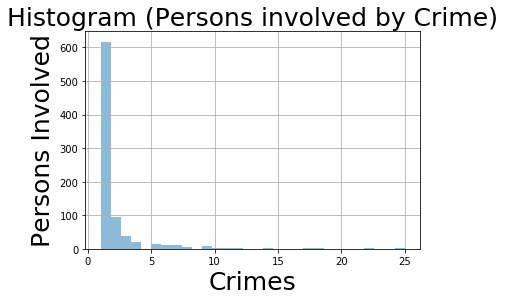

In [133]:
crime_count = pd.DataFrame({'Crime_Count' : crime_file.groupby(['Person']).size()}).reset_index()
crime_count.iloc[:,1].plot.hist(alpha = 0.5, bins = 30)
plt.title('Histogram (Persons involved by Crime)', fontsize = 25)
plt.xlabel('Crimes', fontsize = 25)
plt.ylabel('Persons Involved', fontsize = 25)
plt.grid(True)
plt.rcParams['figure.figsize'] = (30, 10)

For each person, we'll check the number of crimes he was involved in and the role(s) he had.  
So, we'll introduce a new variable crime_file_augmented and keep the original crime_file intact.  

In [134]:
crime_file_augmented = crime_file

# Number of crimes.
crime_file_augmented['num_crimes'] = crime_file_augmented.groupby(['Person'])['Crime'].transform('count')

# Number of many Roles.
crime_file_augmented['num_role'] = crime_file_augmented.groupby(['Person', 'Role'])['Crime'].transform('count')

crime_file_augmented.head()

Person  Crime     Role  num_crimes  num_role
0       1      1  Suspect           4         2
1       1      2   Victim           4         2
2       1      3   Victim           4         2
3       1      4  Suspect           4         2
4       2      5   Victim          22         4

We'll verify below that crime_file_augmented.count() contains the same number of records.  

In [135]:
crime_file_augmented.count()

Person        1476
Crime         1476
Role          1476
num_crimes    1476
num_role      1476
dtype: int64

Now, we'll read persons' names and sex from the two entities ent.moreno_crime_crime.person.name and ent.moreno_crime_crime.person.sex join them in one variable person.  

In [136]:
person = pd.read_csv('ent.moreno_crime_crime.person.name', sep='\t', header = None, names = ['Name'])
person['Sex'] = pd.read_csv('ent.moreno_crime_crime.person.sex', header = None)
#
person.loc[person.Sex == 0, ['Sex']] = 'F'
person.loc[person.Sex == 1, ['Sex']] = 'M'
person.head()

Name Sex
0     AbelDennis   M
1     AbramsChad   M
2    AbramsDavid   M
3      AbramsDon   M
4  AbramsRichard   M

In [137]:
print("Number of person records: ", person.count())

Number of person records:  Name    829
Sex     829
dtype: int64


This number (829) matches with the number of distinct persons in crime file, which we saw above.

In [138]:
crime_file_augmented.head()

Person  Crime     Role  num_crimes  num_role
0       1      1  Suspect           4         2
1       1      2   Victim           4         2
2       1      3   Victim           4         2
3       1      4  Suspect           4         2
4       2      5   Victim          22         4

In [139]:
crime_file_augmented["Name"] = ""
crime_file_augmented["Sex"] = ""

for i in range(0, len(person)):
    crime_file_augmented.loc[crime_file_augmented.Person == i+1, ['Sex']] = person.iloc[i]["Sex"]
    crime_file_augmented.loc[crime_file_augmented.Person == i+1, ['Name']] = person.iloc[i]["Name"]

crime_file_augmented.head()

Person  Crime     Role  num_crimes  num_role        Name Sex
0       1      1  Suspect           4         2  AbelDennis   M
1       1      2   Victim           4         2  AbelDennis   M
2       1      3   Victim           4         2  AbelDennis   M
3       1      4  Suspect           4         2  AbelDennis   M
4       2      5   Victim          22         4  AbramsChad   M

## Some important overlapping roles

#### In the following we'll explore some overlaps between the roles. In below chunk, we'll observe 4 distinct roles.

In [140]:
set(list(crime_file['Role']))

{'Suspect', 'Victim', 'Victim Suspect', 'Witness'}

In [141]:
suspects = set(crime_file_augmented[crime_file_augmented['Role'] == "Suspect"].iloc[:, 5])
victims = set(crime_file_augmented[crime_file_augmented['Role'] == "Victim"].iloc[:, 5])
witnesses = set(crime_file_augmented[crime_file_augmented['Role'] == "Witness"].iloc[:, 5])
victim_suspects = set(crime_file_augmented[crime_file_augmented['Role'] == "Victim Suspect"].iloc[:, 5])

print() 
print('Overlaps of Suspect, Victim, Witness, Victim Suspects')
print('-----------------------------------------------------')
print('Suspects:                                  ', len(suspects))
print('Victims:                                   ', len(victims))
print('Witnesses:                                 ', len(witnesses))
print('Victim Suspects:                           ', len(victim_suspects))
print()
print('Suspects  INTERSECTION Victims:            ', len(suspects.intersection(victims)))
print('Suspects  INTERSECTION Witnesses:          ', len(suspects.intersection(witnesses)))
print('Suspects  INTERSECTION Victim Suspects:    ', len(suspects.intersection(victim_suspects)))
print('Victims   INTERSECTION Witnesses:          ', len(victims.intersection(witnesses)))
print('Victims   INTERSECTION Victim Suspects:    ', len(victims.intersection(victim_suspects)))
print('Witnesses INTERSECTION Victim Suspects:    ', len(witnesses.intersection(victim_suspects)))


Overlaps of Suspect, Victim, Witness, Victim Suspects
-----------------------------------------------------
Suspects:                                   412
Victims:                                    369
Witnesses:                                  189
Victim Suspects:                            40

Suspects  INTERSECTION Victims:             94
Suspects  INTERSECTION Witnesses:           41
Suspects  INTERSECTION Victim Suspects:     10
Victims   INTERSECTION Witnesses:           52
Victims   INTERSECTION Victim Suspects:     15
Witnesses INTERSECTION Victim Suspects:     7


## Bipartite Graph
In the following, we'll build node for graphical interface. 

In [146]:
G = nx.Graph()
#
for i in range(len(crime_file_augmented)):
    G.add_node(crime_file_augmented.iloc[i][5],
               Relation = crime_file_augmented.iloc[i][2],
               rel_count = crime_file_augmented.iloc[i][3],
               weight = crime_file_augmented.iloc[i][4],
               Sex = crime_file_augmented.iloc[i][6],
               bipartite = 1)

print("Node info after adding persons")
print(nx.info(G))
print()

#
#
#
# Adding crime nodes.
for i in range(len(crime_file_augmented)): 
    G.add_node(crime_file_augmented.iloc[i][1], bipartite = 0)

print("Node info after crimes")
print(nx.info(G))
print()

#
#
#
# Adding edges.
for i in range(len(crime_file_augmented)):
    G.add_edge(crime_file_augmented.iloc[i][5], crime_file_augmented.iloc[i][1], weight = 1)

print("Node info after edges")
print(nx.info(G))
print()

Node info after adding persons
Name: 
Type: Graph
Number of nodes: 829
Number of edges: 0
Average degree:   0.0000

Node info after crimes
Name: 
Type: Graph
Number of nodes: 1380
Number of edges: 0
Average degree:   0.0000

Node info after edges
Name: 
Type: Graph
Number of nodes: 1380
Number of edges: 1476
Average degree:   2.1391



We learn that this graph is not a connected graph, but bipartite.

In [147]:
print("Is node connected: ", nx.is_connected(G), "   ", "Is node bipartite: ", nx.is_bipartite(G)) 

Is node connected:  False     Is node bipartite:  True


Take a look at the top ten nodes.

In [148]:
top_nodes = set(n for n, d in G.nodes(data = True) if d['bipartite'] == 1)
#
for i in range(10):
    print (' %s    ' % (list(top_nodes)[i]))

 DerbyTammy    
 KiplingerLisa    
 JeffersonTara    
 RogersKaren    
 CaronMolly    
 WilliamsSherman    
 JeffersonAlbert    
 WaltersJoe    
 CraigRoger    
 BerberPhilippe    


## Graph this bipartite
Now, we'll see some graphics.

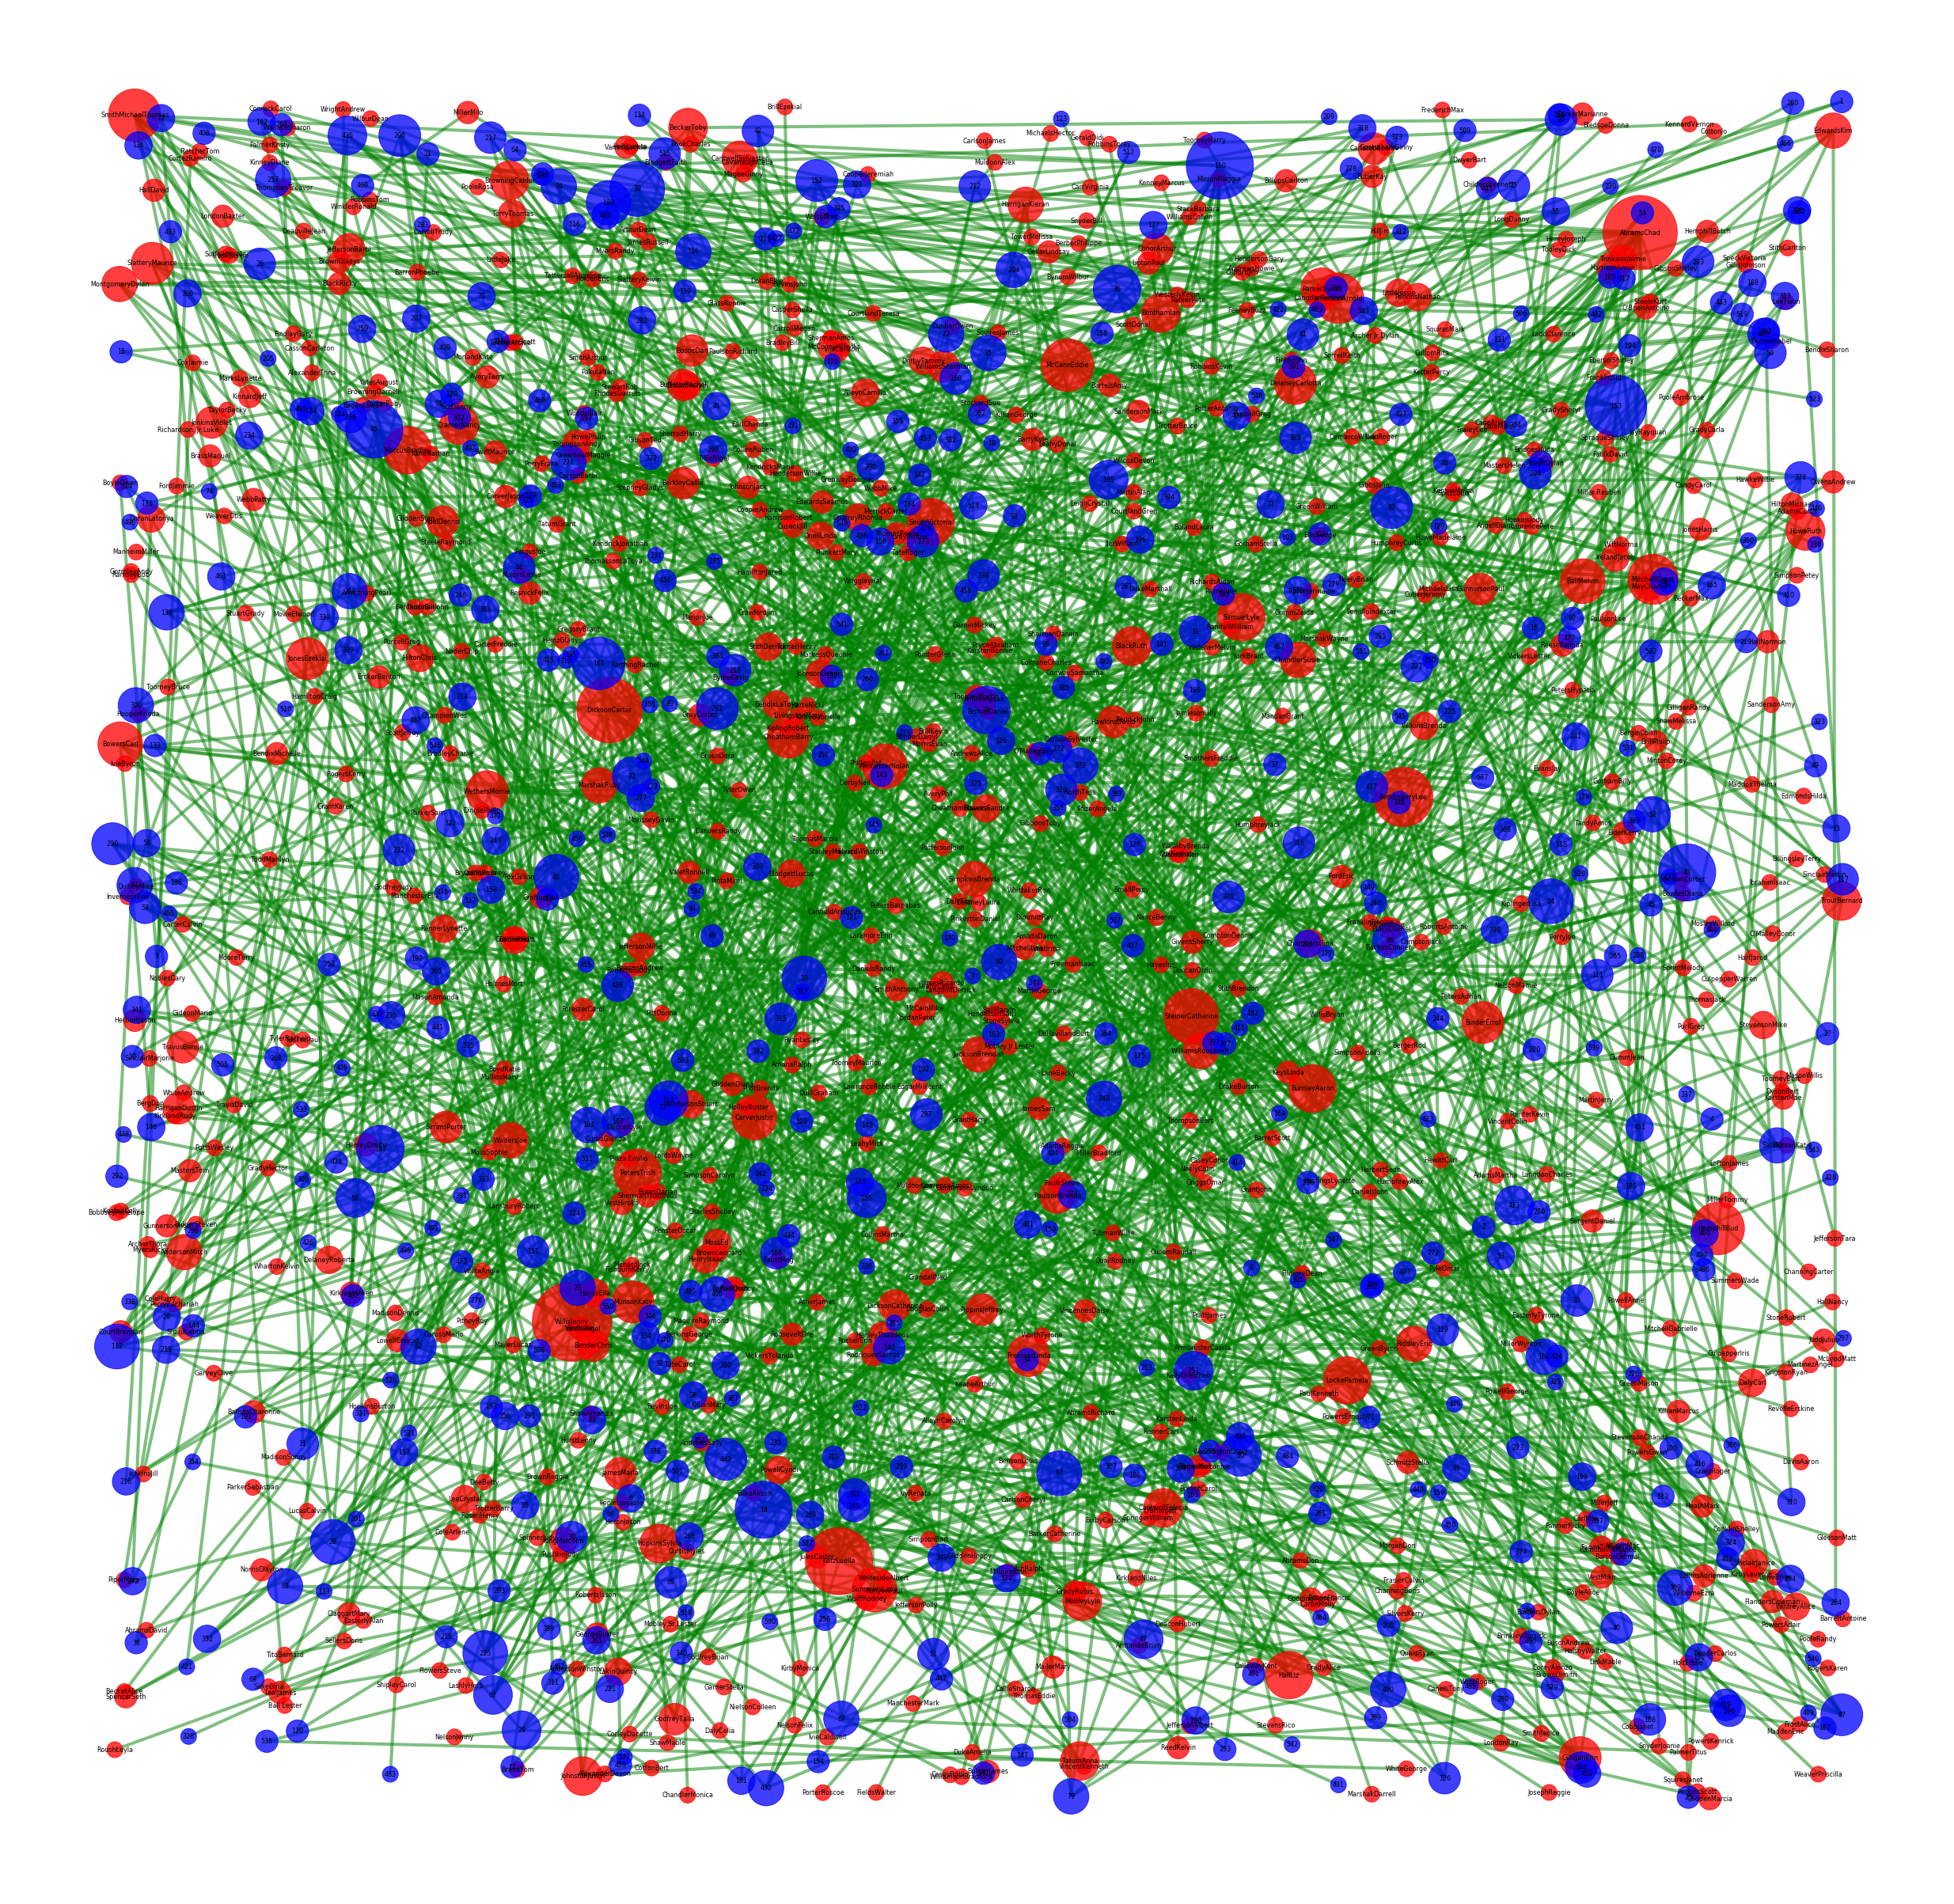

In [149]:
pos = nx.random_layout(G) # positions for all nodes
plt.figure(figsize = (44, 44))

colors = []
for n in dict(G.degree()).keys():    
    if n in dict(G.degree(top_nodes)).keys():
        colors.append('r')
    else:
        colors.append('b')

d = G.degree()
nx.draw_networkx_nodes(G,pos, node_color = colors, node_size = [v*400 for v in dict(d).values()], alpha=0.75)

# edges
nx.draw_networkx_edges(G,pos, width = 4, alpha = 0.5, edge_color = 'g', style = 'solid')

# labels
nx.draw_networkx_labels(G, pos, font_size = 8, font_family = 'sans-serif')

plt.axis('off')
plt.show()

## Person - Bipartite Projection

#### 1. Island Method and analysis

After creating the weighted bipartite graph, we'll use isalnd method. Weights are the number of shared neighbors for an edge. First we'll isolate the biggest component of the bipartite graph, then we'll apply the island method and print the threshold, size and the number of connected components. 

In [151]:
def trim_edges(g, weight = 1):
    g2 = nx.Graph()
    for f, to, edata in g.edges(data = True):
        if edata['weight'] > weight:
            g2.add_edge(f, to)
    return g2

def island_method(g, iterations = 5):
    weights = [edata['weight'] for f,to,edata in g.edges(data = True)]
    mn = int(min(weights))
    mx = int(max(weights))
    step = int((mx - mn) / iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn, mx)]

#### 2. Island method results
As we'll see in the following, a threshold value of 2 results in a network of 28 Persons and 12 connected components. Of particular interest are suspect nodes connected to one Luella Katz, the most-connected suspect in the graph with a degree centrality of 51. Katz is also connected to two other high-degree suspects, Michael Thomas Smith (33 degrees) and Catherine Steiner (29). Both are in the top 10 list of suspects by degree centrality.

In [152]:
cc = list(nx.connected_component_subgraphs(nx.bipartite.weighted_projected_graph(G, top_nodes)))[0]

Island analysis on the graph.

In [153]:
islands = island_method(cc, 3)
#
print ('')
print ('Threshold |  Size (Persons)  |  Connected Components')
print ('----------------------------------------------------')
#
for island in islands:
    print('   %d               %2d                   %2d' 
          %(island[0], len(island[1]), len(list(nx.connected_component_subgraphs(island[1]))))) 


Threshold |  Size (Persons)  |  Connected Components
----------------------------------------------------
   1               89                   27
   2               28                   12
   3               15                    7
   4                6                    3


#### 3. Graph with treshhold of 2.

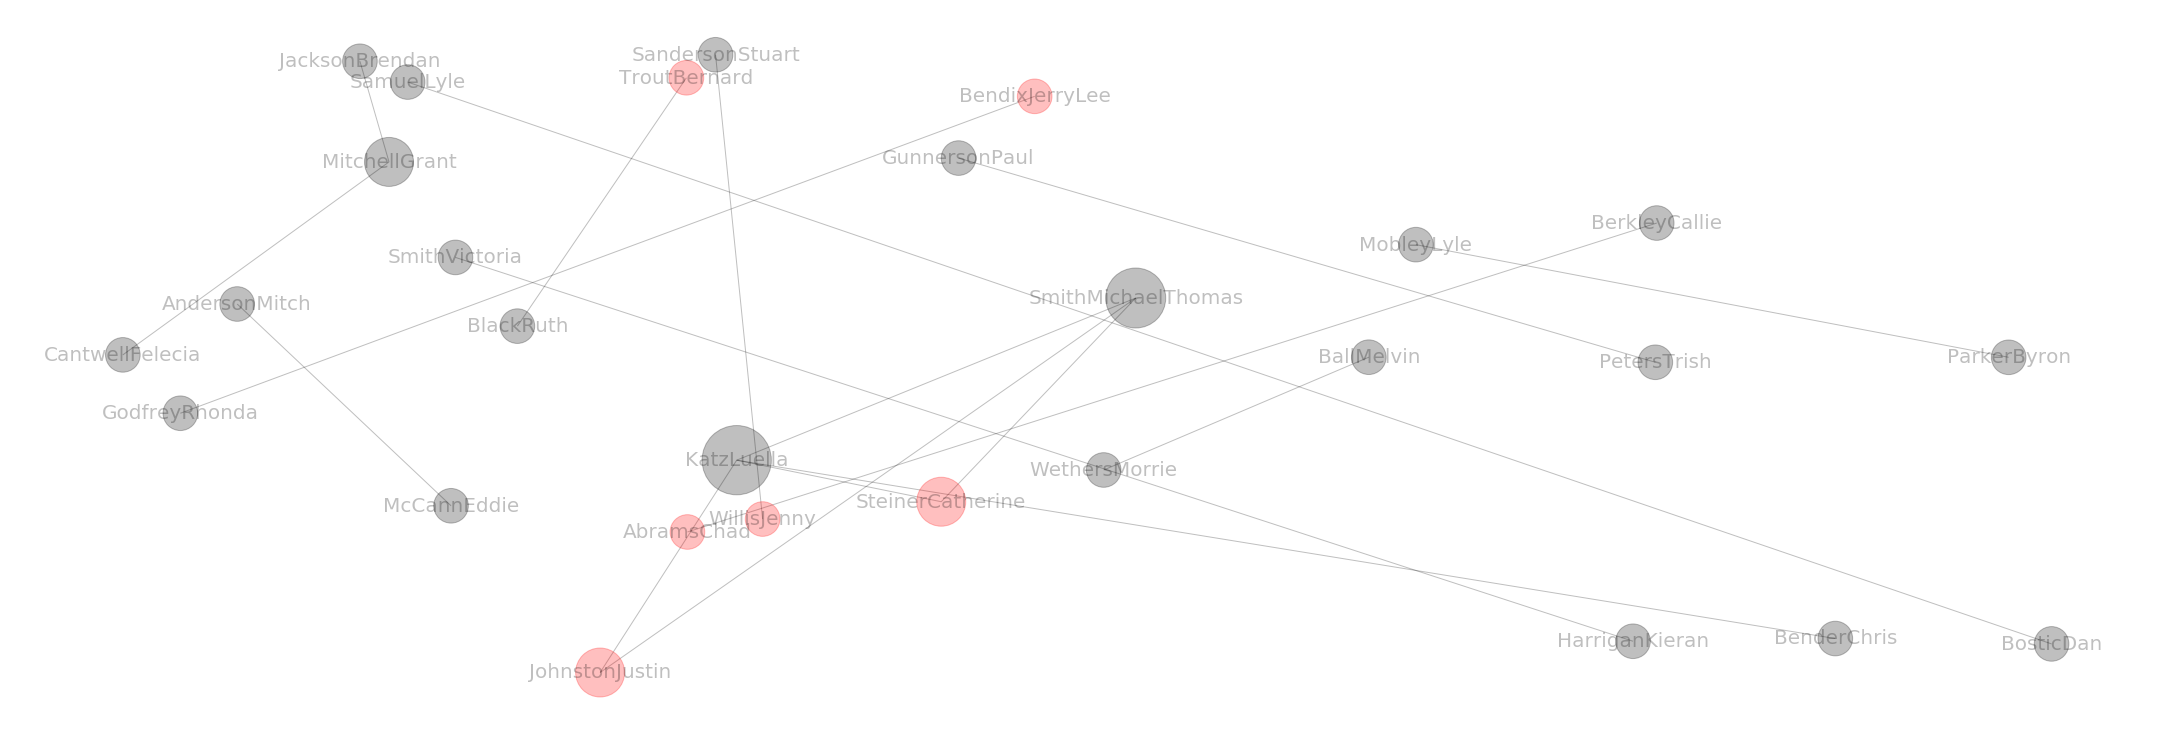

In [154]:
pc = trim_edges(cc, 2)
#
nodecolors = []
for n in dict(pc.degree(top_nodes)).keys():
    if n in suspects:
        nodecolors.append('#000000')
    elif n in victims:
        nodecolors.append('#FF0000')
    else:
        nodecolors.append('#FFFF00')
#
dpc = pc.degree()
nx.draw_random(pc, node_size = [v * 1200 for v in dict(dpc).values()], with_labels = True, node_color = nodecolors, alpha = 0.25, font_size= 20)

#### 4. What about the person Katz. Let's give him a visit and check his ego network.

#### Katz's connections to other people, who are themselves involved as suspects in 40 crimes and as victims in 22 crimes.

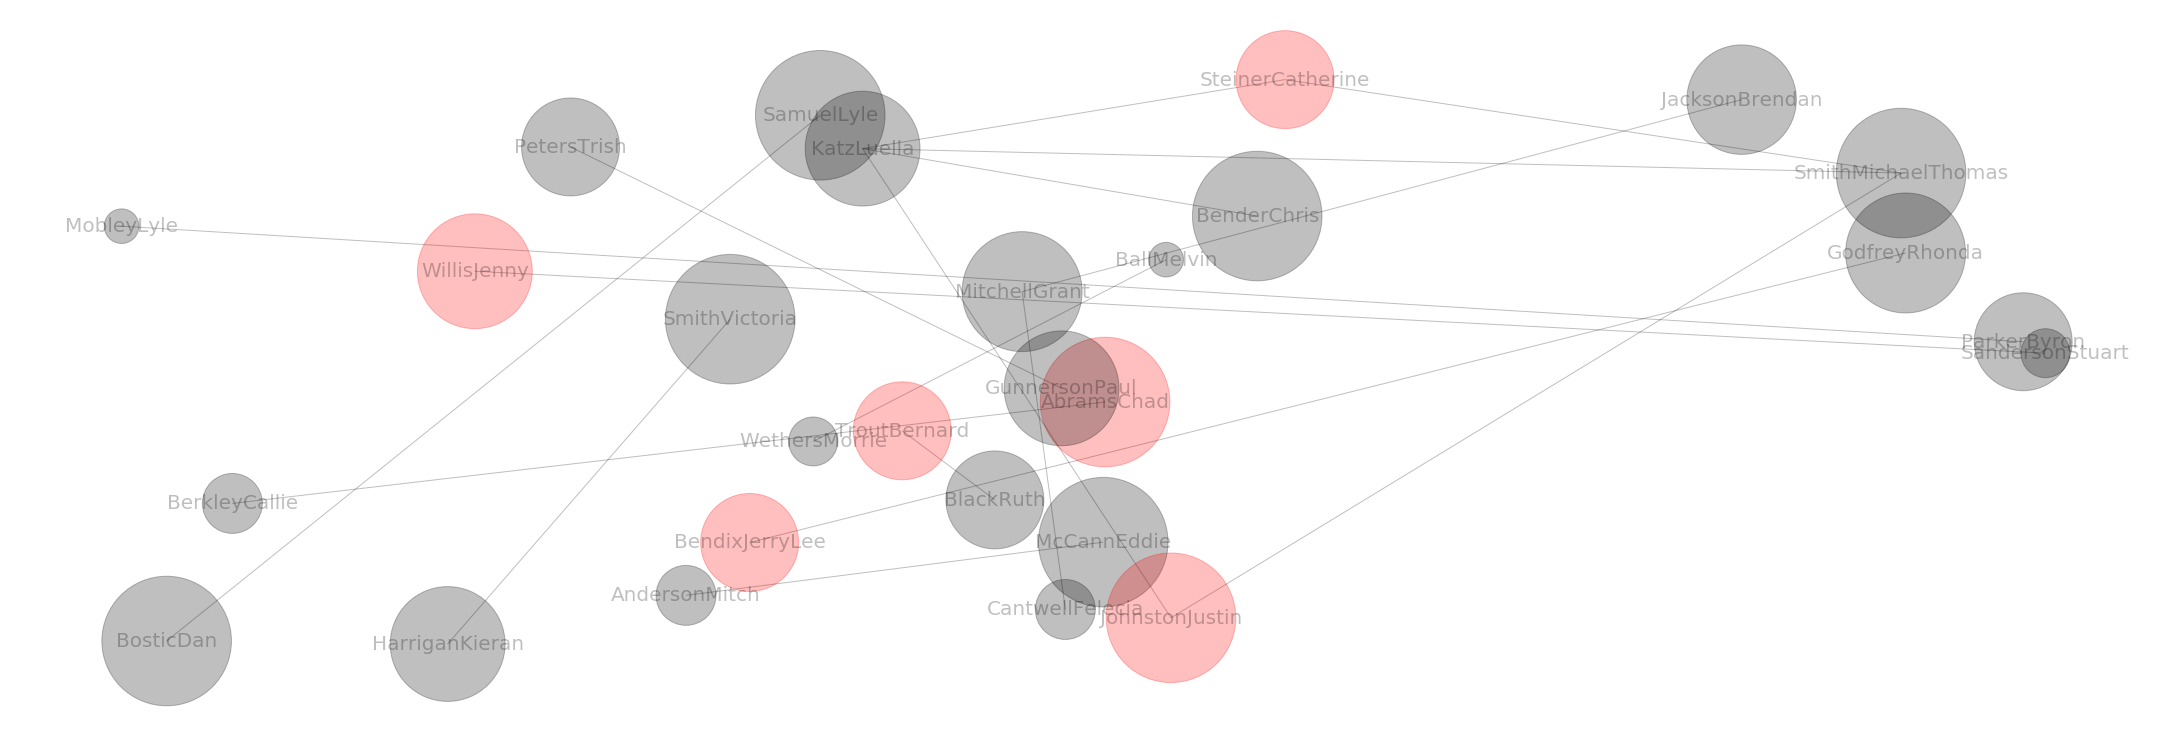

In [155]:
luella_katz = nx.ego_graph(PC, 'KatzLuella', radius = 1, center = True, undirected = True, distance = 'weight')

nodecolors = []
for n in dict(pc.degree(top_nodes)).keys():
    if n in suspects:
        nodecolors.append('#000000')
    elif n in victims:
        nodecolors.append('#FF0000')
    else:
        nodecolors.append('#FFFF00')

dkatz = luella_katz.degree()
nx.draw_random(pc, node_size = [v * 1200 for v in dict(dkatz).values()], with_labels = True, node_color = nodecolors, 
               alpha = .25, font_size = 20)

In [156]:
luella_katz = crime_file_augmented[crime_file_augmented['Name'] == 'KatzLuella']
katz_connections = pd.DataFrame(cc.edges('KatzLuella'))
katz_con = set(katz_connections.iloc[:, 1])
katz_intersect_victims = len(katz_con.intersection(victims))
katz_intersect_suspects = len(katz_con.intersection(suspects))
#
print ('Luella Katz:')
print ('------------------------')
print ('Victim connections:  ', katz_intersect_victims)
print ('Suspect connections: ', katz_intersect_suspects)

Luella Katz:
------------------------
Victim connections:   22
Suspect connections:  40


## Crimes - Bipartite Projection

#### Set of Crime nodes and the relation between them, based on the same person.

In [157]:
bottom_nodes = set(G) - top_nodes
cc2 = nx.bipartite.weighted_projected_graph(G, bottom_nodes)

#### 1. Crimes - island Analysis

The island analysis identifies a six-node network of crimes. Examination of the crimes shows they were all involved with Luella Katz and close associates, who were suspects, if not criminals. Katz was a witness in crime 110 along with 14 other individuals.

In [158]:
## Run the Island Analysis on the graph
islands = island_method(cc2, iterations = 2) 

print ('Depth  Crime  Networks')
print ('************************')
for island in islands:
    print(' %d      %3d      %2d' 
          %(island[0], len(island[1]), len(list(nx.connected_component_subgraphs(island[1])))))
    

Depth  Crime  Networks
************************
 1      119      36
 2       10       3


#### 2. The graph

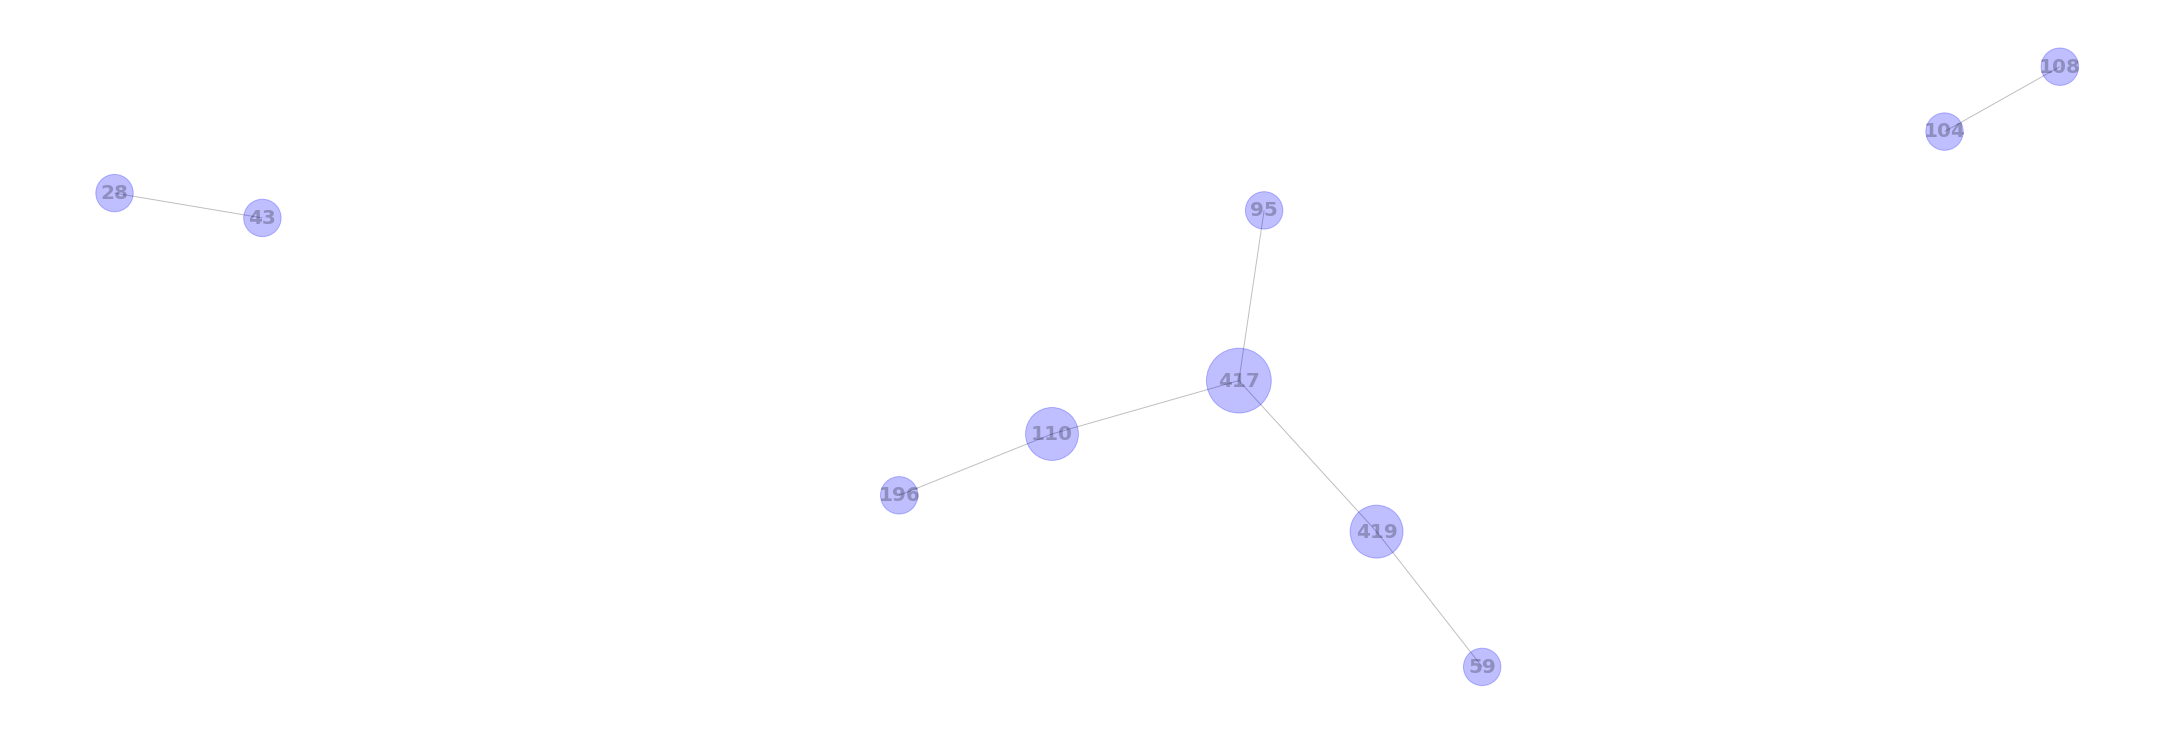

In [159]:
# 2 graphs created by the island analysis:
wc = trim_edges(cc2, 2)
dwc = wc.degree()
nx.draw(wc, node_size = [v * 1400 for v in dict(dwc).values()], with_labels = True, node_color = 'b', alpha = .25, font_weight = 'bold', font_size = 20)
